In [1]:
from SimPlots import *

# Simulating SARS-CoV-2 SSE

<img src="../MarkdownFiles/figures/figure_1.png" alt="SSE1" width="1000"/>

## Procedure for Generating Transmission Tree

1. **Parameters:**
    - `size_sse`: The number of initial infections resulting from SSE.
    - `R0`: The basic reproduction number.
    - `k`: Dispersion parameter for the negative binomial distribution.
    - `n_generations`: Number of generations for the transmission tree.

2. **Simulate Generations:**
   - For each generation:
     1. **Generate New Infections:**
        - Use the negative binomial distribution to determine the number of new infections for each current infector.
     2. **Select Infectees:**
        - Randomly select susceptible individuals to be new infectees.
        - Update the list of susceptible individuals by removing the new infectees.
     3. **Assign Infectees to Infectors:**
        - Pair each infector with their assigned infectees.
        - Record these new transmission pairs.
     4. **Update Populations:**
        - Update the list of current infectors to the new infectees.
        - I assume infinite number of susceptible individuals

3. **Create Transmission Tree:**
   - Initialize a directed graph.
   - Add all recorded transmission pairs as edges in the graph.

### Procedure for Generating Epidemiological Data During An Outbreak

To simulate epidemiological data for in an outbreak initiated by superspreader event (SSE), I start with an initial group of people being infected by a superspreader over a period of ≥1 day, beginning from date 0 when the superspreader becomes infectious. Using a simulated transmission tree represented by a graph $G$, I generate exposure and sampling dates for each node in the tree using the following procedure:

### Root Node (Superspreader, Index 0)

1. **Latent Period ($\text{E} \rightarrow \text{O}_\text{I}$)**:

   The latent period is the time between exposure ($\text{E}$) to the pathogen and the onset of infectiousness ($\text{O}_\text{I}$). During this period, an infected individual is not yet capable of transmitting the pathogen to others. Understanding this period is crucial as it marks when an infected person begins contributing to the spread of the disease.

   - For COVID-19, research suggests the latent period follows different probability distributions based on research findings, but it has typically been modelled as a log-normal distribution. Different studies report different mean latent period estimates, generally around 5 days [(Ref)](https://doi.org/10.1093/cid/ciab746), [(Ref)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9186332/), and it can vary based on the virus strain and individual characteristics [(Ref)](https://doi.org/10.1186/s12879-024-09158-7). For the Omicron variant, the mean latent period is approximately 2.65 days [(Ref)](https://doi.org/10.1186/s12879-024-09158-7).

   - I model the latent period $ (\text{E} \rightarrow \text{O}_\text{I}) $ as a log-normal distribution: $(\text{E} \rightarrow \text{O}_\text{I}) \sim \text{Lognormal}(\mu_{Lp}, \sigma_{Lp}) $

     where $\mu_{Lp}$ is the average latent period $L_p$, and $\sigma_{Lp}$ is the standard deviation which can be used to model the level of noise/variability in the distribution. At $\sigma = 1$, the variance-mean ratio is 0 and the distribution collapses to the mean $L_p$.

   - The exposure date for the superspreader ($\text{E}_0$) is set to: $ \text{E}_0 = - (\text{E} \rightarrow \text{O}_\text{I})_0 $, assuming the superspreader became infectious at time 0.

2. **Onset of Infectiousness to Onset of Symptom ($\text{O}_\text{I} \rightarrow \text{O}_\text{sym}$)**:

   The time from the onset of infectiousness to the onset of symptoms ($\text{O}_\text{S}$) can also be modelled using a lognormal distribution [(Ref)](https://doi.org/10.1371/journal.pcbi.1009149): $ (\text{O}_\text{I} \rightarrow \text{O}_\text{sym}) \sim \text{Lognormal}(\mu, \sigma) $. Here $\mu$ can be inferred from the average incubation period ($I_p$) which is generally longer than or equal to the average latent period $L_p$ [(Ref)](https://doi.org/10.1093/cid/ciab746). Pre-symptomatic transmissions may occur during this period. $\mu = I_p - L_p$.

3. **Symptom Onset to Testing Date ($\text{O}_\text{S} \rightarrow \text{T}$)**:

   The interval from symptom onset to getting tested ($\text{T}$) can vary based on healthcare-seeking behaviour, accessibility of testing facilities, and public health guidelines [(Ref)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7901514/). This interval can be modelled using a gamma distribution: $ (\text{O}_\text{sym} \rightarrow \text{T}) \sim \text{Gamma}(k_{test}, \theta_{test}) $, assuming testing of only symptomatic cases.

4. **Testing Date ($T_0$)**:

   The testing date is calculated by summing the latent period, the time from onset of infectiousness to symptom onset, and the time from symptom onset to testing:
   $$
   \text{T}_0 = \text{E}_0 + (\text{E} \rightarrow \text{O}_\text{I}) + (\text{O}_\text{I} \rightarrow \text{O}_\text{sym})_0 + (\text{O}_\text{sym} \rightarrow \text{T})_0
   $$

   $$
   \text{T}_0 = (\text{O}_\text{I} \rightarrow \text{O}_\text{sym})_0 + (\text{O}_\text{sym} \rightarrow \text{T})_0
   $$

### Successors of the Root Node (Primary SSE Cases)

1. **Exposure Date ($\text{E}_{\text{primary successor}}$)**:

   The exposure date for the successor is drawn from a uniform distribution over the duration of the SSE:
   $$
   \text{E}_{\text{primary successor}} = \text{uniform}(0, \text{duration of SSE})
   $$

2. **Testing Date ($\text{T}_{\text{primary successor}}$)**:

   The sampling date for the successor is calculated similarly to the root node:
   $$
   \text{T}_{\text{primary successor}} = \text{E}_{\text{primary successor}} + (\text{E} \rightarrow \text{O}_\text{I})_\text{primary successor} + (\text{O}_\text{I} \rightarrow \text{O}_\text{sym})_\text{primary successor} + (\text{O}_\text{S} \rightarrow \text{T})_\text{primary successor}
   $$

### Other Successors (Onward Transmissions)

1. **Exposure Date ($\text{E}_{\text{secondary successor}}$)**:

   The interval from the onset of infectiousness in the predecessor to the time of transmission to the successor can be modelled with a gamma distribution: $ (\text{O}_\text{I} \rightarrow \text{T}_\text{rans}) \sim \text{Gamma}(k_{trans}, \theta_{trans})$. A gamma distribution captures the findings that most of the transmissions (86%) occur within 5 days postonset of symptoms. The initial $\theta$ values for $(\text{O}_\text{I} \rightarrow \text{T}_\text{rans})$ and $(\text{O}_\text{sym} \rightarrow \text{T})$ gamma distributions can be set to reflect this. 

    **References**
      1. [https://bmjopen.bmj.com/content/10/8/e039856](https://bmjopen.bmj.com/content/10/8/e039856)
      2. [https://doi.org/10.1093/cid/ciab746](https://doi.org/10.1093/cid/ciab746)
      3. [https://assets.publishing.service.gov.uk/media/641c7a9b32a8e0000cfa9327/COVID-19-infectiousness-_asymptomatic-transmission.pdf](https://assets.publishing.service.gov.uk/media/641c7a9b32a8e0000cfa9327/COVID-19-infectiousness-_asymptomatic-transmission.pdf)

    $$
    \text{E}_{\text{secondary successor}} = \text{E}_{\text{predecessor}} + (\text{E} \rightarrow \text{O}_\text{I})_\text{predecessor} + (\text{O}_\text{I} \rightarrow \text{T}_\text{rans})_\text{predecessor}
    $$

2. **Testing Date ($\text{T}_{\text{secondary successor}}$)**:

     $$
     \text{T}_{\text{secondary successor}} = \text{E}_{\text{secondary successor}} + (\text{E} \rightarrow \text{O}_\text{I})_\text{secondary successor} + (\text{O}_\text{I} \rightarrow \text{O}_\text{sym})_\text{secondary successor} + (\text{O}_\text{sym} \rightarrow \text{T})_\text{secondary successor}
     $$

In [4]:
plot_epi_time_scales_model(betas={"noise_exp_inf": 5, "noise_inf_sym": 5, "scale_inf_trans": 2, "scale_sym_test": 1})

interactive(children=(FloatSlider(value=4.0, description='Latent Period', layout=Layout(height='40px', margin=…

### Sequence Evolution Over Transmission Tree

I start with the sequence that infected the index case and evolve it over the tree by mutating the sequence based on the time interval between the infector's (predecessor) exposure date and the infectee's (successor) testing date. This approach simplifies the process compared to a two-step method.

In the two-step method, I would:
1. Evolve the sequence transmitted to the predecessor up to the time of transmission.
2. Then evolve this sequence from the successor exposure up to sampling.

Since the overall time interval in both methods is the same, from the predecessor's exposure to the successor's testing, I opted for the simpler approach of directly evolving the sequence from the predecessor's exposure to the successor's testing date.

$$
\text{evolve_period} = |\text{E}_{\text{successor}} - \text{E}_{\text{predecessor}}|
$$

I model the observable number of substitutions ($N_{Obs}$) as a Poisson process: $N_{Obs} \sim \mathcal{P}(\lambda)$

Where:

  - $\lambda$ is given by $\text{evolve_period} \times \text{clock rate}$ in substitutions per genome per day.

This process generates the exposure and testing dates for each individual in the transmission tree, capturing the stochastic nature of disease spread and sampling.

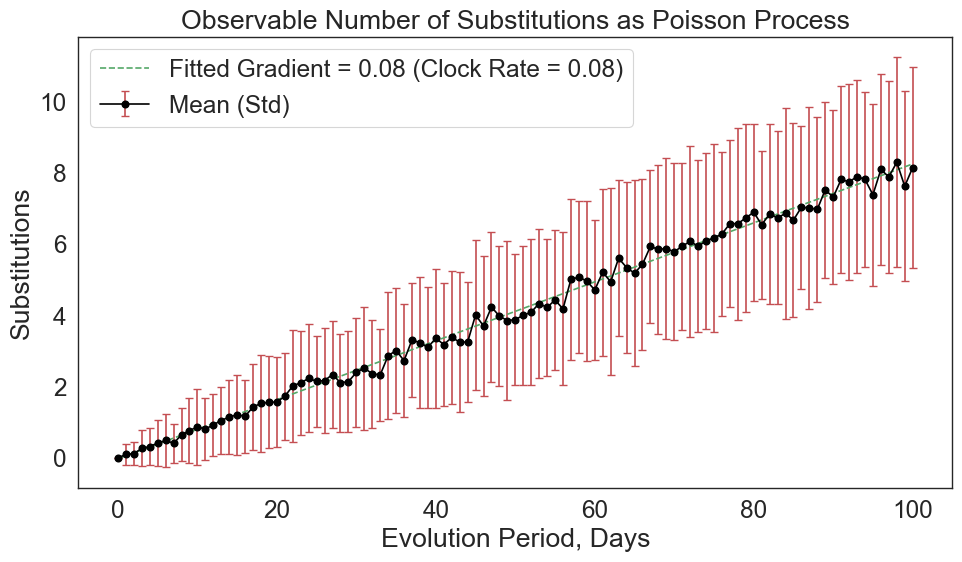

In [4]:
plot_poisson_subs_model(num_runs=100)

## Demo

In [2]:
param_dict = {
    "size_sse": 30,
    "R0": 1.5,
    "k": 0.5,
    "n_generations": 5,
    "generation_time": 5,
    "gen_length": 1000,  # Didn't use actual genome length 29903 to reduce computational time
    "clock_rate": 0.08,  # (1e-3 / 365) * 29903 substitution rate (number of mutations per genome per year)
    "dur_sse": 1,
    "base": False,
    "prop_sampled": 0.5,
    
    "latent_period": 4,
    "incubation_period": 5,
    
    "noise_exp_inf": 1.05,
    "noise_inf_sym": 1.01,
    
    "shape_sym_test": 3,
    "scale_sym_test": 1.1,
    
    "shape_inf_trans": 4,
    "scale_inf_trans": 1,
    "alpha": 0.0,
    "betas": {"noise_exp_inf": 5, "noise_inf_sym": 5, "scale_inf_trans": 2, "scale_sym_test": 1}
}

para_name = "alpha"
param_range = [0.0]

simulations = run_simulations(param_dict, para_name, param_range, num_sims=1)
# sc.save("../OutputFiles/Simulations/ro_simulations.obj", simulations)

Job 1/1 (1.6 s) •••••••••••••••••••••••••••••• 100%
Simulation Done
alpha : [0.0]

Elapsed time: 1.68 s


In [6]:
base_param_dict = param_dict.copy()
base_param_dict["scale_sym_test"] = 0
base_param_dict["scale_inf_trans"] = 0
base_param_dict["noise_exp_inf"] = 1
base_param_dict["noise_inf_sym"] = 1
base_param_dict["base"] = True

base_sim = run_simulations(base_param_dict, para_name, param_range)
# sc.save("../OutputFiles/Simulations/base_ro_simulation.obj", base_sim)

Job 1/1 (2.1 s) •••••••••••••••••••••••••••••• 100%
Simulation Done
alpha : [0.0]

Elapsed time: 2.23 s


In [7]:
# base_sim = sc.load("../OutputFiles/Simulations/base_ro_1.5_simulation.obj")
# simulations = sc.load("../OutputFiles/Simulations/ro_1.5_simulations.obj")

### Moment Estimate of Dispersion Parameter $k$
The moment estimate for the dispersion parameter $k$ in a negative binomial distribution can be calculated using the sample mean $\bar{x}$ and sample variance $s^2$.

$$ k = \frac{\bar{x}^2}{s^2 - \bar{x}} $$

The method is not suitable for small datasets.

In [8]:
prior_k = 0.5
prior_RO = 1.5
p = prior_k / (prior_k * prior_RO)

nb_data = np.random.negative_binomial(n=prior_k, p=p, size=10000)
moment_estimate_k(nb_data)

0.53

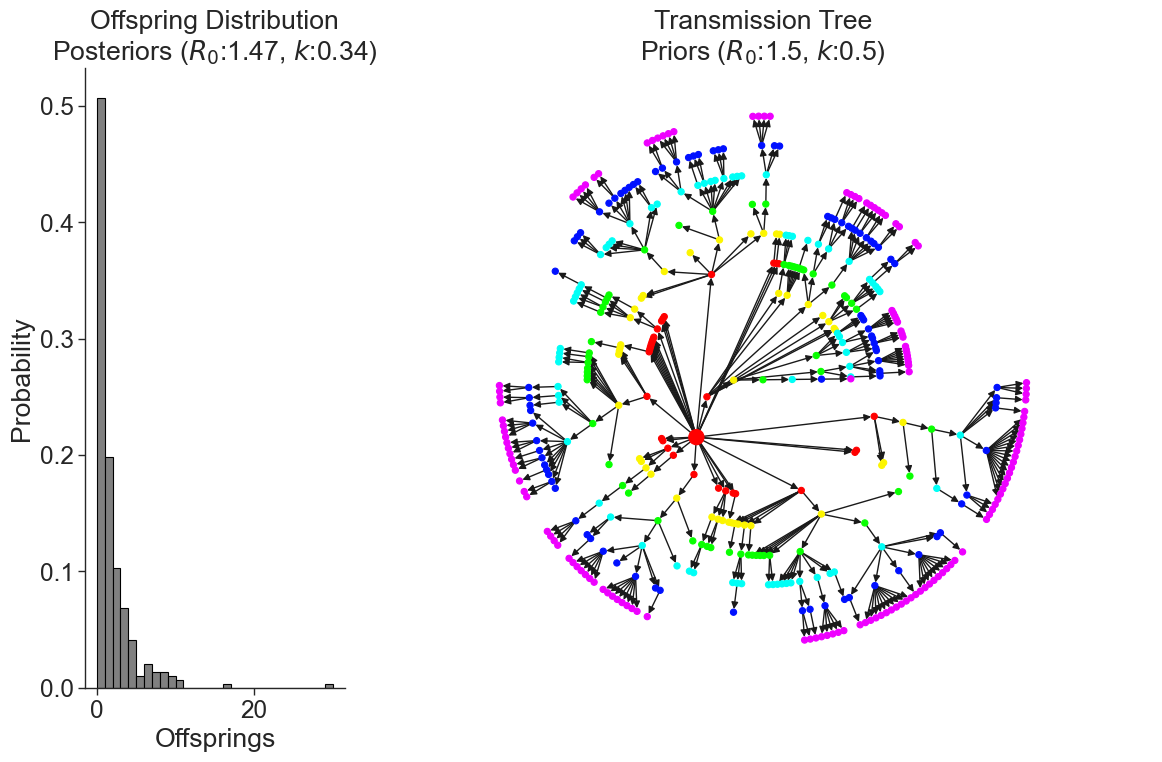

In [3]:
visualize_trans_tree(simulations[0][0])

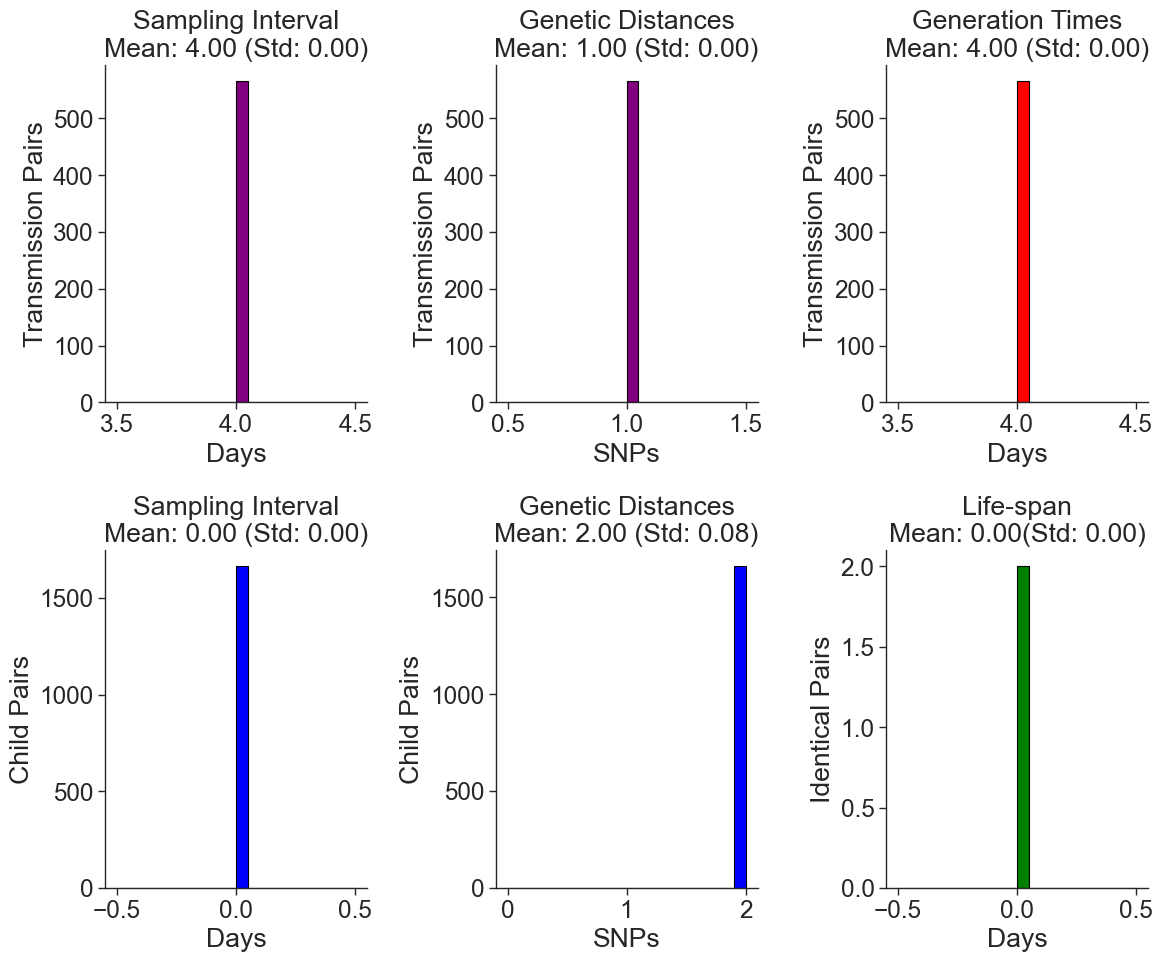

In [10]:
plot_epi_data(base_sim[0][0])

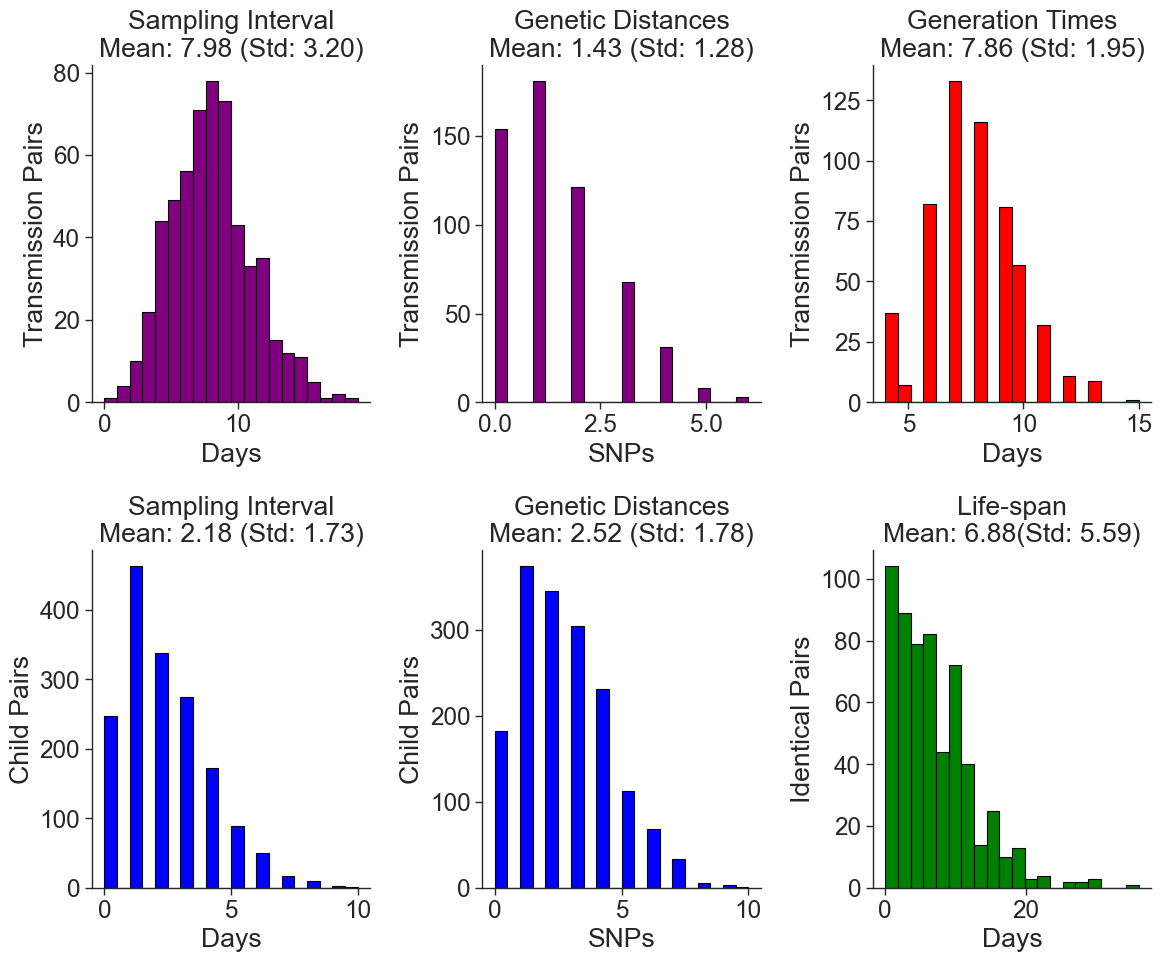

In [11]:
plot_epi_data(simulations[0][0])

## Choosing Optimum Clustering Parameters

**Should I Choose a constant probability and resolution for further analysis?**
- There is a trade-off between Purity and Completeness
- There seems to be randomness to the community detection method. Different output on different runs
- When looking at method performance, consider quality and clustering stability which is influenced by high density graph

### Definition of Metrics for Clustering Evaluation

#### Objective:
The goal is to evaluate the clustering output by comparing it against a known truth set. A ground truth set in this context is a cluster that consists of an infector and all its infectees. For instance, a cluster that includes all superspreading event (SSE) cases and the superspreader is considered a truth set. The output is a list of clusters where each contains at least one element from the truth set. The aim is to measure two aspects:

1. **Cluster Purity**: The extent to which the elements of the clusters in the output are pure subsets of the truth set.
2. **Cluster Completeness**: The extent to which the elements of the truth set are captured together in a single cluster in the output.

3. **Truth Set**:
   - Denoted as $T$, this is the set of elements that represent the ground truth for a single cluster.

4. **Output Clusters**:
   - Denoted as $\{C_1, C_2, \ldots, C_n\}$, this is the list of sets produced by the clustering method.

#### Metrics:

1. **Cluster Purity**:
   - **Definition**: For each output cluster $C_i$, purity is defined as the ratio of elements in $C_i$ that belong to the truth set $T$ to the total number of elements in $C_i$.
     $$
     \text{Purity}(C_i) = \frac{|C_i \cap T|}{|C_i|}
     $$
   - **Interpretation**: This metric measures the purity of each cluster with respect to the truth set. Higher purity indicates that the cluster contains more elements from the truth set.

2. **Cluster Completeness**:
   - **Definition**: Completeness is defined as the maximum ratio of elements of the truth set $T$ that are captured in any single output cluster $C_i$ to the total number of elements in the truth set $T$.
     $$
     \text{Completeness} = \max_{i} \frac{|C_i \cap T|}{|T|}
     $$
   - **Interpretation**: This metric measures how well the clustering method captures the truth set in a single cluster. Higher completeness indicates that a larger portion of the truth set is contained within a single cluster.

3. **Cluster Quality Index (QI)**:
   - **Definition**: QI (or F1-score) is the harmonic mean of purity and completeness, providing a single metric that balances both aspects.
    $$
    \text{QI} = 2 \times \frac{\text{Purity} \times \text{Completeness}}{\text{Purity} + \text{Completeness}}
    $$
  - **Interpretation**: The F-measure provides a balanced metric that considers both the purity and completeness of the clusters. A higher F-measure indicates a better balance between the two, showing that the clustering method captures the truth set well while maintaining high purity within the clusters.

In [12]:
# Example
# output_sets = [{'A', 'B', 'C'}, {'D','E'}, {'A', 'F', 'G'}, {'F', 'G', 'H'}]
output_sets = [{'A'}, {'B'}, {'C'}, {'D'}, {'E'}, {'F'}, {'G'}]
truth = {'A', 'B', 'C', 'D'}
evaluate_clustering(output_sets, truth)

{'Purity': 1.0, 'Completeness': 0.25, 'QI': 0.4}

## Base Simulation

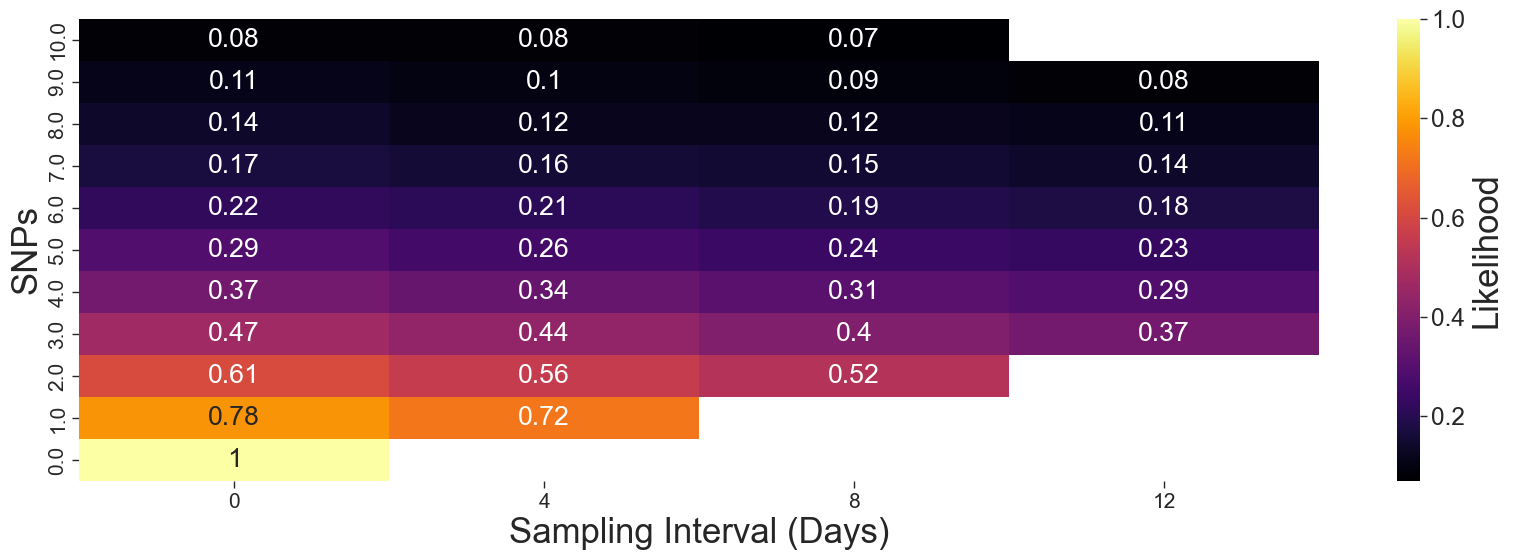

In [13]:
plot_probabilities_heatmap(base_sim[0][0])

## Optimising Only With SSE Cluster

In [14]:
sse_cluster = set(range(31))

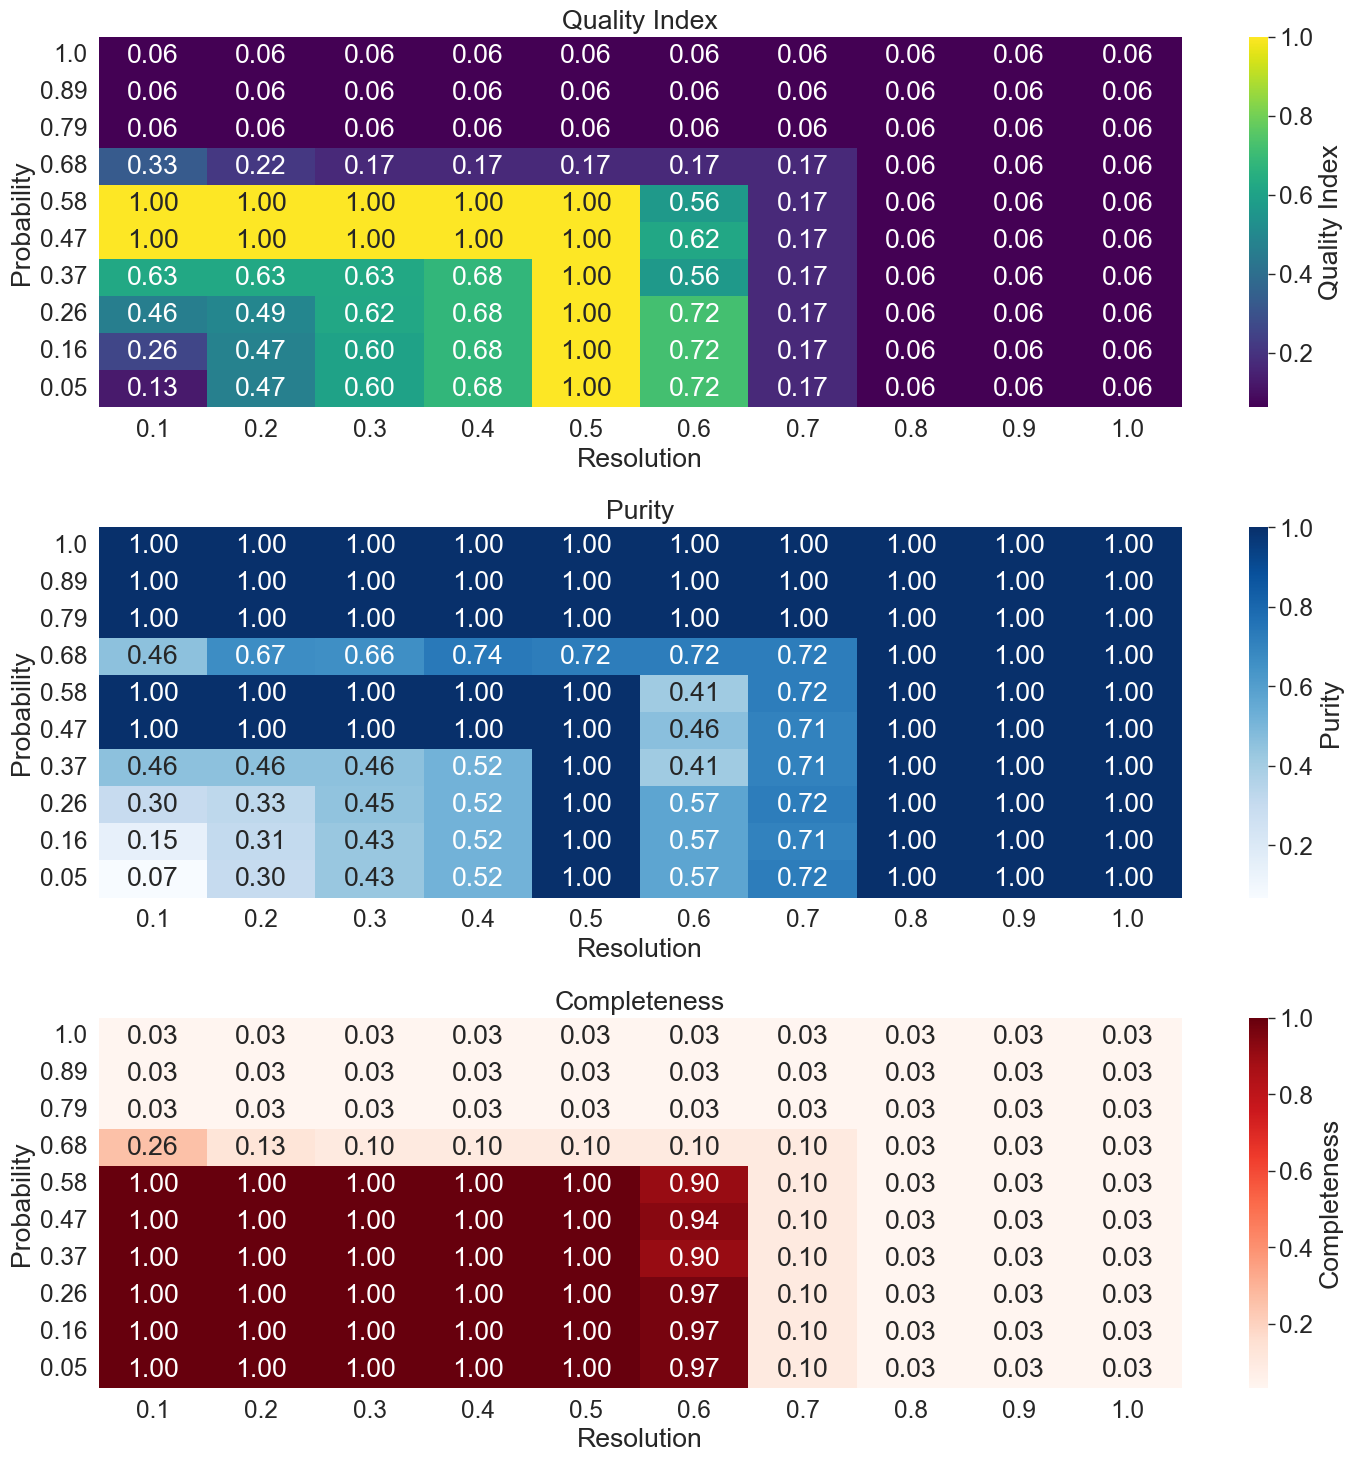

In [16]:
plot_optimising_clustering_parameters(base_sim[0][0])

In [17]:
base_sse_param = get_optimum_clustering_parameters(base_sim[0][0], sse_cluster)
base_sse_param

{'QI': 1.0, 'Probability': 0.5776831414968284, 'Resolution': 0.5}

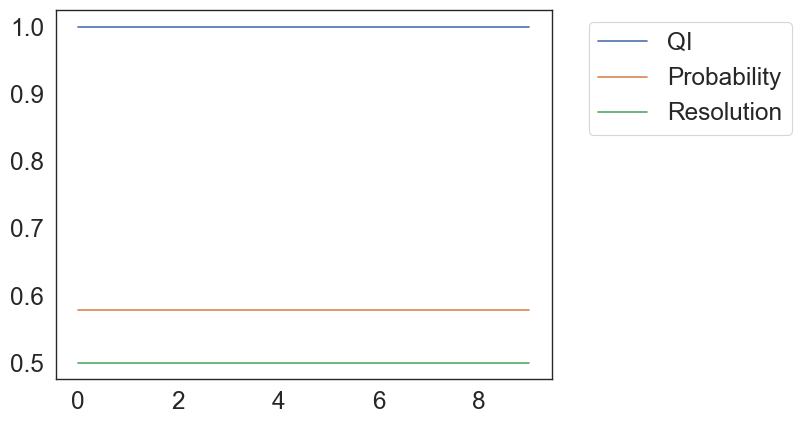

In [18]:
base_params = evaluate_stability_optimisation_method(base_sim[0][0], sse_cluster, runs=10)

base_params.plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

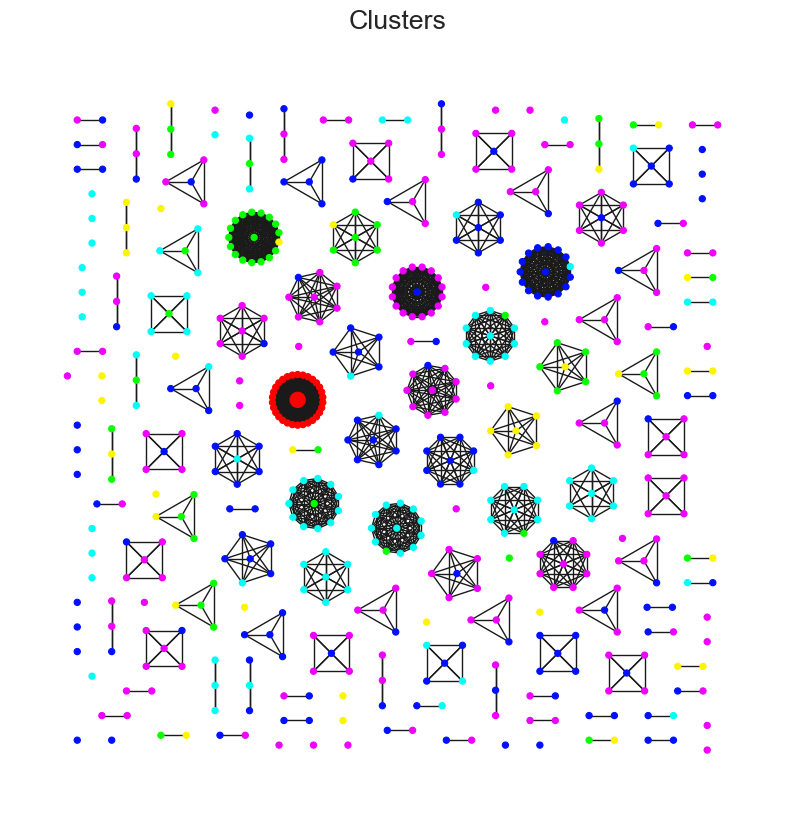

In [21]:
base_predicted_clusters = leiden_community_detection(base_sim[0][0], prob=base_sse_param["Probability"], res=base_sse_param["Resolution"])
plot_clusters(base_predicted_clusters, base_sim[0][0])

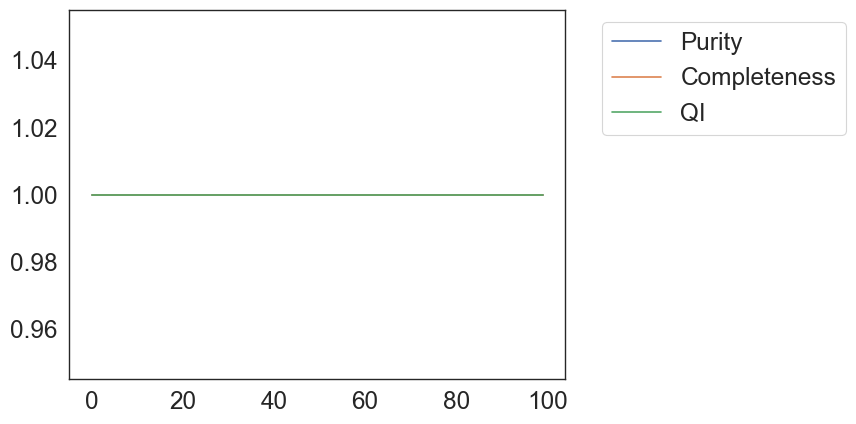

In [19]:
base_cluster_stability = evaluate_stability_of_clustering(base_sim[0][0], prob=base_sse_param["Probability"], res=base_sse_param["Resolution"], runs=100)
base_cluster_stability.plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

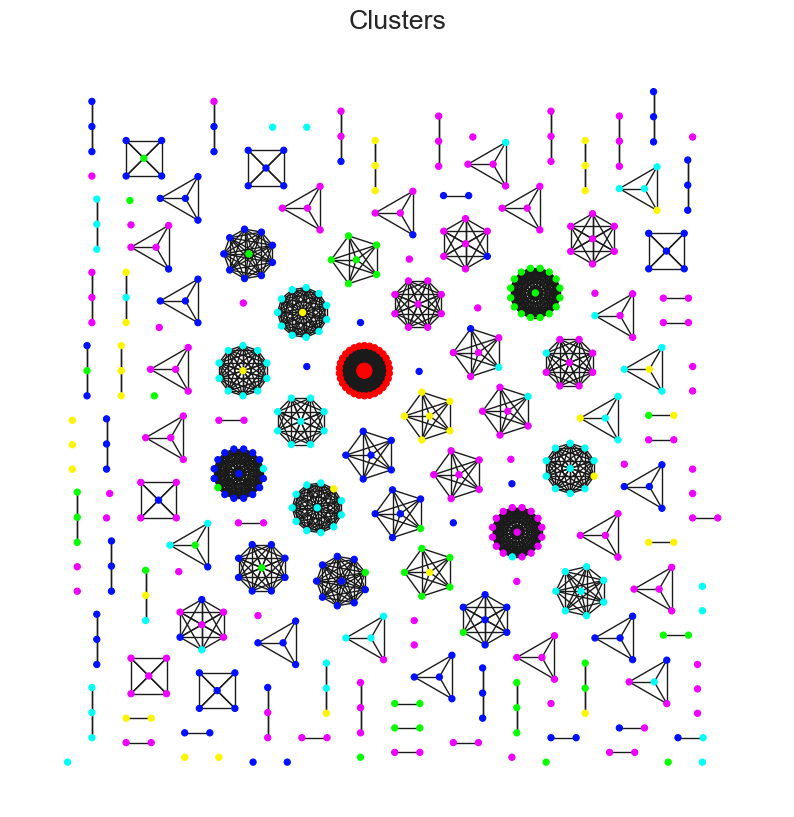

In [22]:
base_predicted_clusters_snp = leiden_community_detection(base_sim[0][0], snp=2, res=base_sse_param["Resolution"], weight="HammingDistance")
plot_clusters(base_predicted_clusters_snp, base_sim[0][0])

In [23]:
evaluate_clustering(base_predicted_clusters, sse_cluster), evaluate_clustering(base_predicted_clusters_snp, sse_cluster)

({'Purity': 1.0, 'Completeness': 1.0, 'QI': 1.0},
 {'Purity': 1.0, 'Completeness': 1.0, 'QI': 1.0})

# Some Noise

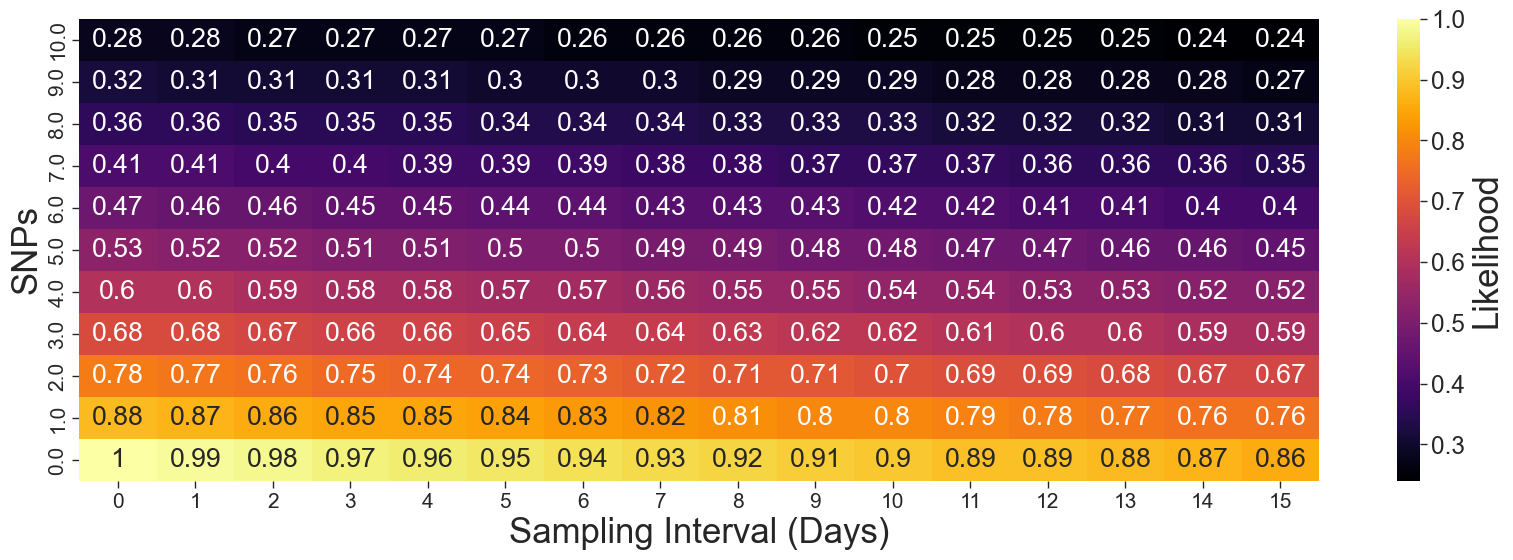

In [24]:
plot_probabilities_heatmap(simulations[0][0])

In [25]:
predicted_clusters = leiden_community_detection(simulations[0][0], prob=base_sse_param["Probability"], res=base_sse_param["Resolution"])

evaluate_clustering(predicted_clusters, sse_cluster)

{'Purity': 0.6805970149253732,
 'Completeness': 0.8709677419354839,
 'QI': 0.7641035188977844}

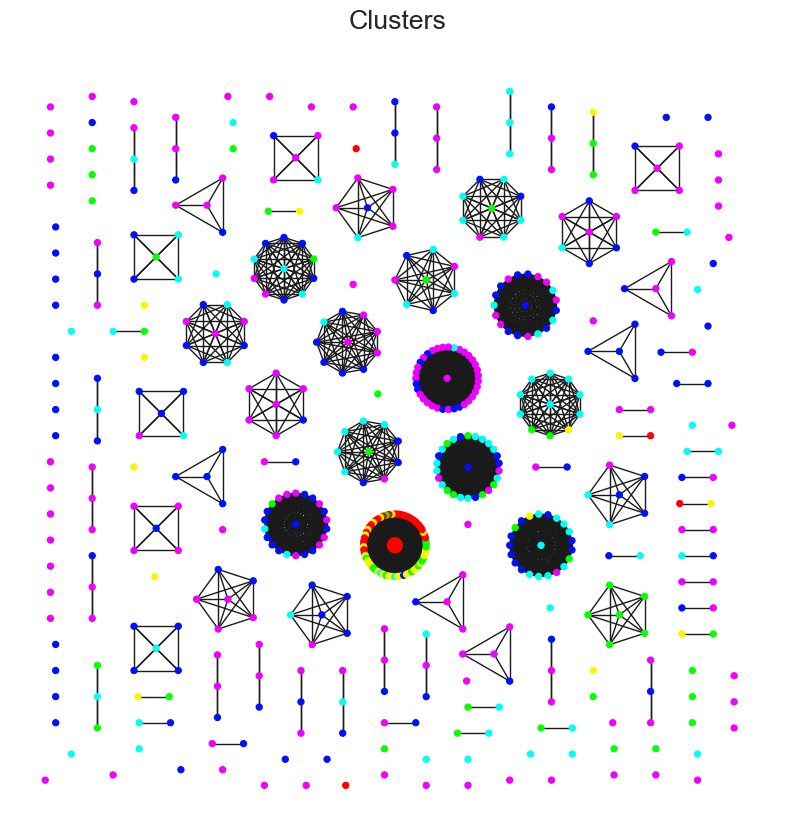

In [26]:
plot_clusters(predicted_clusters, simulations[0][0])

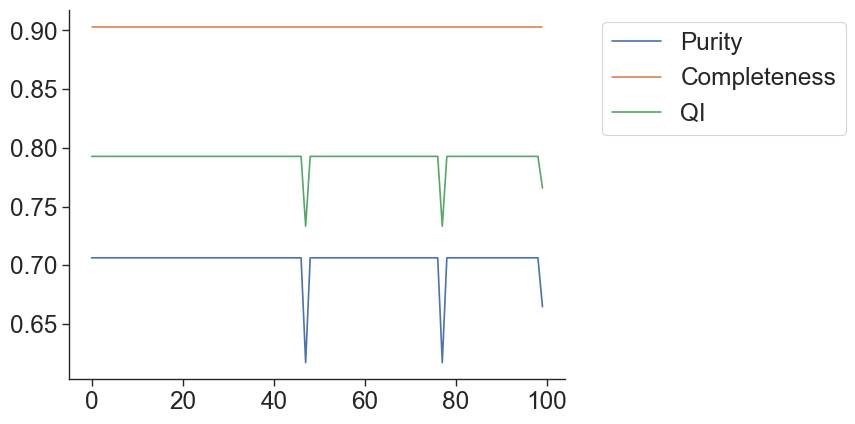

In [27]:
cluster_stability = evaluate_stability_of_clustering(simulations[0][0], prob=base_sse_param["Probability"], res=base_sse_param["Resolution"], runs=100)
cluster_stability.plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [28]:
cluster_stability.describe()

,Purity,Completeness,QI
count,100.000000,1.000000e+02,100.000000
mean,0.704193,9.032258e-01,0.791316
std,0.013179,1.450561e-15,0.008762
min,0.617110,9.032258e-01,0.733245
25%,0.706395,9.032258e-01,0.792776
50%,0.706395,9.032258e-01,0.792776
75%,0.706395,9.032258e-01,0.792776
max,0.706395,9.032258e-01,0.792776


## For All Truth Clusters

In [29]:
def get_optimum_clustering_parameters_all_parallelize(sim, truth_sets):
    def get_parameters(t):
        return get_optimum_clustering_parameters(sim, t)
    params = sc.parallelize(get_parameters, truth_sets)
    return pd.DataFrame(params)

In [30]:
truth_clusters = get_truth_clusters(base_sim[0][0])
truth_sizes = np.array([len(clus) for clus in truth_clusters])

truth_clusters_sig = [clus for clus in truth_clusters if len(clus) >=
                      significant_cluster_size_threshold(r0=base_sim[0][0].R0)]

len(truth_clusters_sig), significant_cluster_size_threshold(r0=base_sim[0][0].R0)

(49, 5)

In [31]:
parameters = get_optimum_clustering_parameters_all_parallelize(base_sim[0][0], truth_clusters_sig)

In [32]:
parameters.describe()

,QI,Probability,Resolution
count,49.000000,49.000000,49.000000
mean,0.899387,0.603539,0.395918
std,0.166974,0.073181,0.209124
min,0.465116,0.366525,0.100000
25%,0.727273,0.577683,0.100000
50%,1.000000,0.577683,0.500000
75%,1.000000,0.683262,0.600000
max,1.000000,0.683262,0.700000


In [33]:
predicted_clusters_mean_params = leiden_community_detection(simulations[0][0], prob=parameters.mean()["Probability"], res=parameters.mean()["Resolution"])

In [34]:
evaluate_clustering(predicted_clusters_mean_params, sse_cluster)

{'Purity': 0.6878109452736318,
 'Completeness': 0.9032258064516129,
 'QI': 0.7809355692850839}

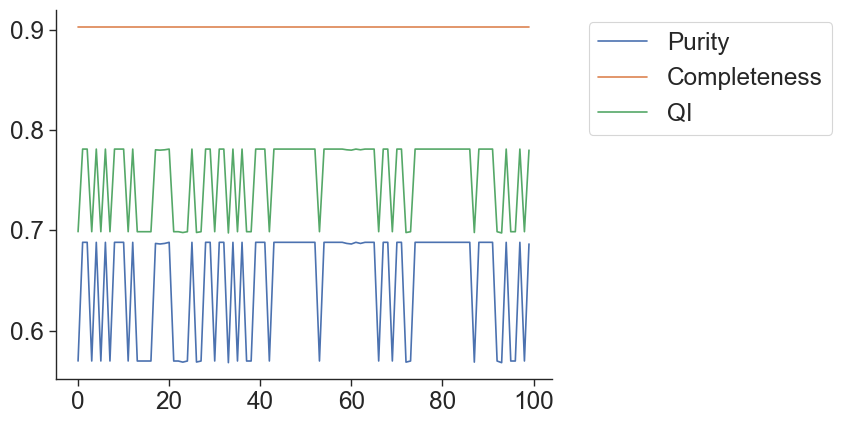

In [35]:
cluster_stability = evaluate_stability_of_clustering(simulations[0][0], prob=parameters.mean()["Probability"], res=parameters.mean()["Resolution"], runs=100)
cluster_stability.plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [37]:
cluster_eva = evaluate_clustering_all(predicted_clusters_mean_params, truth_clusters_sig)

In [38]:
cluster_eva.describe()

,Purity,Completeness,QI
count,49.000000,49.000000,49.000000
mean,0.629031,0.728635,0.629523
std,0.237682,0.226138,0.208677
min,0.138889,0.200000,0.243902
25%,0.520833,0.600000,0.500000
50%,0.626667,0.800000,0.638298
75%,0.785714,0.875000,0.780936
max,1.000000,1.000000,1.000000
